In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время.

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Все значения подтипов ```float``` в тип ```float```
2. ```object``` в ```category```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



In [10]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 924.3 MB


In [12]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 792.6 MB


In [14]:
print(f'train_df decreased on {100 - (memory_usage(train_df) * 100)/2567.094} %')
print(f'test_df decreased on {100 - (memory_usage(test_df) * 100)/2214.031} %')

train_df decreased on 63.989099234193674 %
test_df decreased on 64.19355467369698 %


Видим, что объём памяти, занимаемый каждым датасетом после преобразования типов признаков уменьшился примерно на ```64``` %

#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [15]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    len_df = len(df)
    mis_val_percent = 100 * mis_val / len_df
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

In [16]:
missing_values_table(train_df, 'train_df')

train_df has  434 columns.
 There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
...,...,...
V285,12,0.0
V284,12,0.0
V280,12,0.0
V279,12,0.0


In [17]:
missing_values_table(test_df, 'test_df')

test_df has  433 columns.
 There are 385 columns that have missing values.


,Missing Values,% of Total Values
id-24,501951,99.1
id-25,501652,99.0
id-26,501644,99.0
id-08,501632,99.0
id-07,501632,99.0
...,...,...
V293,3,0.0
C14,3,0.0
V319,3,0.0
V292,3,0.0


Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [18]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

In [19]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,C,13832,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173000,C,3154,408.0,185.0,mastercard,224.0,debit,...,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удаляем признаки, в которых более ```50 %``` пропусков:

In [20]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 214 columns.


In [21]:
train_df = train_df.drop(columns = missing_columns)

In [22]:
train_df.shape

(590540, 220)

In [23]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 219)

Посмотрим ещё раз на пропуски 

In [24]:
miss_val_train_df = missing_values_table(train_df, 'train_df')
miss_val_train_df

train_df has  220 columns.
 There are 200 columns that have missing values.


,Missing Values,% of Total Values
M4,281444,47.7
D2,280797,47.5
V7,279287,47.3
V11,279287,47.3
V10,279287,47.3
...,...,...
V295,12,0.0
V297,12,0.0
V298,12,0.0
V299,12,0.0


In [25]:
missing_values_table(test_df, 'test_df')

test_df has  219 columns.
 There are 171 columns that have missing values.


,Missing Values,% of Total Values
M4,237745,46.9
D2,234769,46.3
D3,203142,40.1
M3,176639,34.9
M2,176639,34.9
...,...,...
V287,3,0.0
V290,3,0.0
V292,3,0.0
V293,3,0.0


И посмотрим насколько ещё уменьшился занимаемый объём памяти каждого из датасетов

In [26]:
print(f'train_df memory usage: {memory_usage(train_df)} Mb')
print(f'test_df memory usage: {memory_usage(test_df)} Mb')

train_df memory usage: 477.58735275268555 Mb
test_df memory usage: 409.29405784606934 Mb


### Разделим обучающую выборку на обучение и тест

Отделим данные от целевой переменной

In [27]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: uint8

Разделим обучающую выборку в процентном соотношении:
- train - ```70%```
- test - ```30%```

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

In [30]:
X_train.shape

(413378, 219)

In [31]:
y_train.shape

(413378,)

In [32]:
X_valid.shape

(177162, 219)

In [33]:
y_valid.shape

(177162,)

### Посмотрим на распределения признаков до заполнения пропусков

#### Посмотрим на распределение целевой переменной ```isFraud```

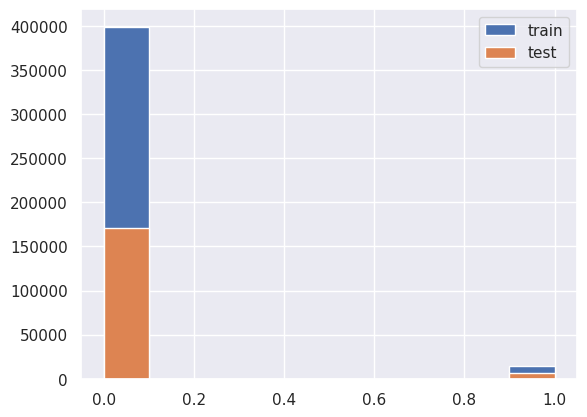

In [34]:
sns.set()
plt.hist(y_train, label='train')
plt.hist(y_valid, label='test')
plt.legend()

In [35]:
isFraud_count = y_train.value_counts()
isFraud_prct = y_train.value_counts()/len(y_train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,398914,0.96501
1,14464,0.03499


In [36]:
isFraud_count = y_valid.value_counts()
isFraud_prct = y_valid.value_counts()/len(y_valid)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,170963,0.965009
1,6199,0.034991


Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

Напишем функцию для построения распределений признаков

In [37]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                            figsize=(7,5),
                                            xlabel=title,
                                            ylabel='count',
                                            edgecolor='k',
                                            color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

#### Распределение ```Card 4``` (компания карты)

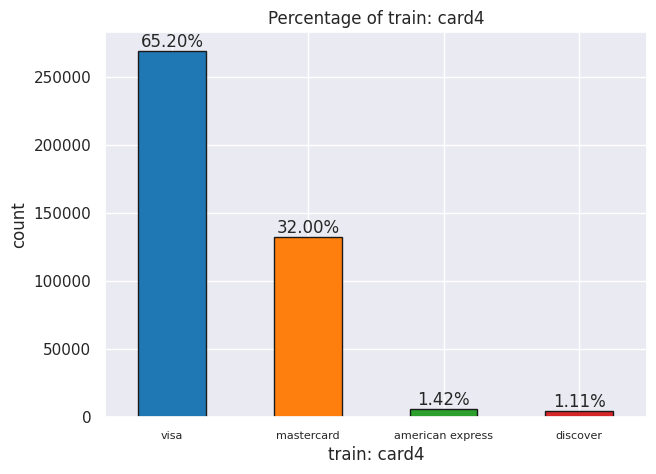

In [38]:
plot_value_counts('card4', 'train: card4', df=X_train)

Видим, что:

- ```65,34 %``` - карт компании 'visa'
- ```31,61 %``` - 'mastercard'
- ```1,68 %```  - 'american express'
- ```1,16 %```  - 'discover'

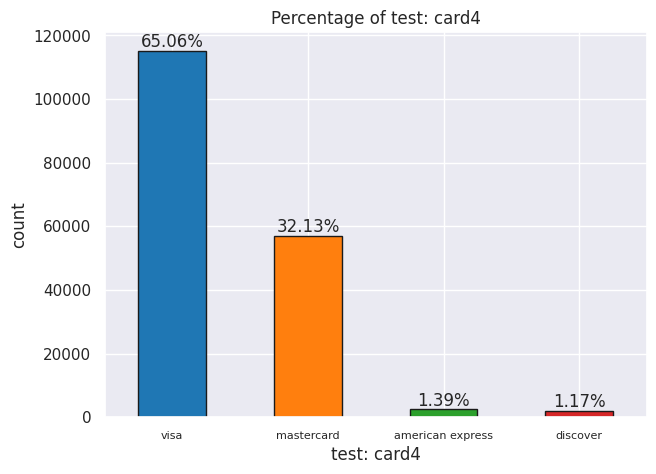

In [39]:
plot_value_counts('card4', 'test: card4', df=X_valid)

#### Распределение ```Card 6``` - тип карты

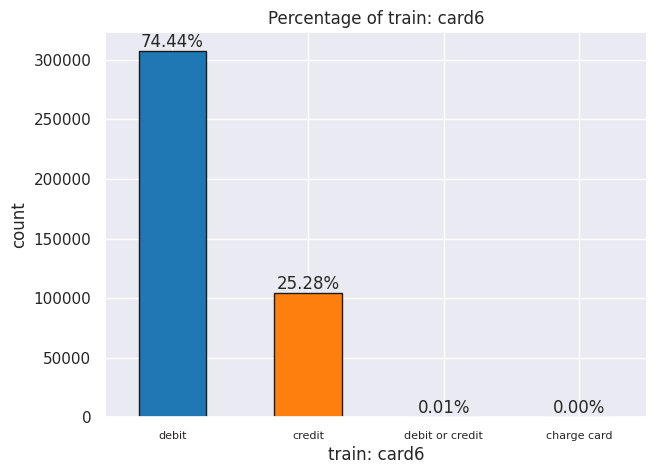

In [40]:
plot_value_counts('card6', 'train: card6', df=X_train)

Большая часть транзакций произведена дебетовыми картами - ```73,17 %```, ```26,61 %``` - кредитными картами. Транзакций с ```charge``` карт нет

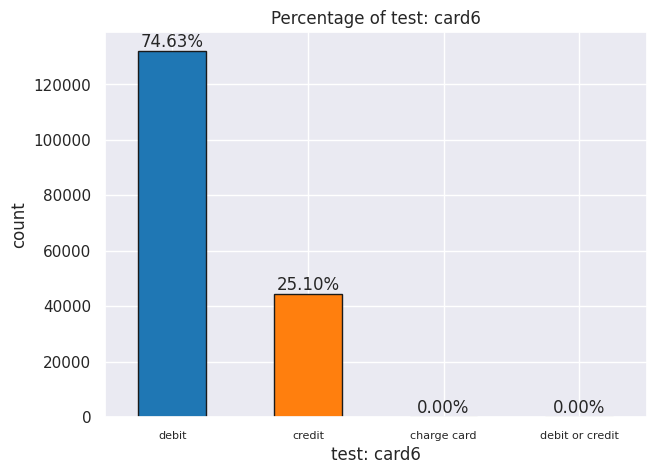

In [41]:
plot_value_counts('card6', 'test: card6', df=X_valid)

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [42]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

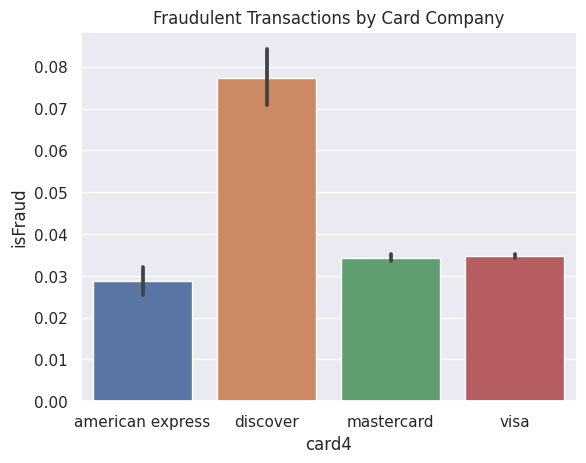

In [43]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

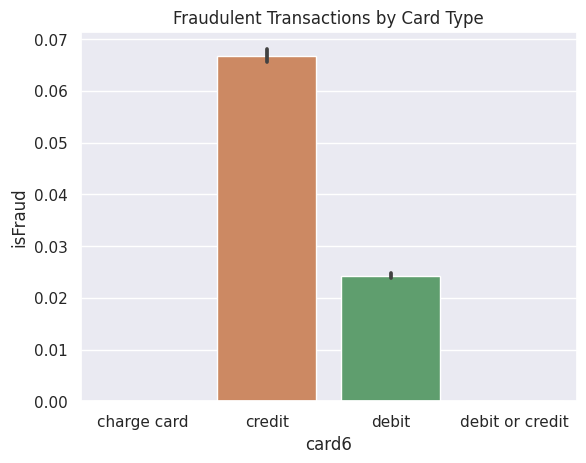

In [44]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

### Посмотрим, есть ли в данных дубликаты

In [45]:
X_train.duplicated().sum()

0

In [46]:
X_valid.duplicated().sum()

0

### Преобразуем категориальные признаки в числа

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 266381 to 317434
Columns: 219 entries, TransactionID to V321
dtypes: category(9), float32(207), uint16(1), uint32(2)
memory usage: 337.1 MB


In [48]:
for f in X_train.columns:
    if X_train.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_train.loc[:, f].values))
        X_train.loc[:, f] = le.transform(list(X_train.loc[:, f].values))

In [49]:
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
266381,3253381,6456381,365.000000,4,1893,514.0,150.0,2,224.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242160,3229160,5735385,3080.969971,4,11207,361.0,150.0,4,226.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13803,3000803,402672,75.000000,1,8908,583.0,150.0,4,226.0,1,...,0.0,0.0,0.0,0.0,75.0,75.0,75.0,75.0,75.0,75.0
135424,3122424,2731680,39.000000,4,7919,194.0,150.0,2,202.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98374,3085374,1985221,100.000000,1,1043,399.0,150.0,0,146.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53761,3040761,1269188,664.000000,4,10616,583.0,150.0,4,226.0,1,...,931.0,395.0,1326.0,395.0,664.0,664.0,664.0,0.0,417.5,0.0
23471,3010471,599531,59.000000,4,15497,490.0,150.0,4,226.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,59.0,59.0
445180,3432180,11318519,67.949997,4,15238,543.0,150.0,2,224.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407369,3394369,10282735,58.970001,4,17009,111.0,150.0,4,195.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
for f in X_valid.columns:
    if X_valid.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_valid.loc[:, f].values))
        X_valid.loc[:, f] = le.transform(list(X_valid.loc[:, f].values))

In [51]:
X_valid

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
509548,3496548,13354870,59.000000,4,2803,100.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,59.0,0.0
18764,3005764,500420,140.000000,4,11207,361.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
138429,3125429,2827784,28.216999,0,9633,296.0,185.0,4,138.0,2,...,0.0,0.0,0.000000,0.0,169.303207,169.303207,169.303207,0.0,0.0,0.0
367372,3354372,9135955,138.000000,4,17892,126.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
290347,3277347,7155271,59.000000,4,1039,391.0,150.0,4,166.0,2,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254882,3241882,6106281,100.000000,1,12544,321.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
524523,3511523,13793173,54.500000,4,9992,455.0,150.0,2,126.0,2,...,0.0,54.5,54.500000,54.5,0.000000,0.000000,0.000000,0.0,0.0,0.0
140267,3127267,2863769,35.950001,4,2803,100.0,150.0,4,226.0,2,...,0.0,0.0,87.949997,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
407762,3394762,10290223,58.950001,4,15847,216.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [52]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,C,13832,375.0,185.0,mastercard,224.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506687,4170236,34214287,12.173000,C,3154,408.0,185.0,mastercard,224.0,debit,...,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

In [54]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.950001,4,10409,111.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,...,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,284.950012,4,10989,360.0,150.0,4,166.0,2,...,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.949997,4,18018,452.0,150.0,2,117.0,2,...,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,0,13832,375.0,185.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506687,4170236,34214287,12.173000,0,3154,408.0,185.0,2,224.0,2,...,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0
506688,4170237,34214326,49.000000,4,16661,490.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506689,4170238,34214337,202.000000,4,16621,516.0,150.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляция признаков

Выведем корреляции признаков в виде списка и отсортируем значения по убыванию. Отберём признаки с высокой корреляцией (>0.7)

In [55]:
df_corr = X_train.corr()

corrs = []
for feat1 in df_corr:
    for i, feat2 in enumerate(df_corr):
        corrs.append((feat1, feat2, df_corr[feat1].values[i]))
sorted_corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
max_sorted_corrs = [sort_tuple for sort_tuple in sorted_corrs \
                    if sort_tuple[0]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[1]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[-1] > 0.7 \
                    and sort_tuple[-1] < 1.0]
max_sorted_corrs[:30]

[('C7', 'C12', 0.9994907578299814),
 ('C1', 'C11', 0.9965514812308824),
 ('C1', 'C2', 0.9951604156956837),
 ('C2', 'C1', 0.9951604156956837),
 ('C2', 'C11', 0.9940382989992362),
 ('C6', 'C11', 0.9912336986327435),
 ('C7', 'C10', 0.9854412453769772),
 ('C6', 'C14', 0.9843553250739188),
 ('C7', 'C8', 0.983464324820937),
 ('C1', 'C6', 0.9824761121049799),
 ('C6', 'C1', 0.9824761121049799),
 ('D1', 'D2', 0.9811592664026938),
 ('D2', 'D1', 0.9811592664026938),
 ('C2', 'C8', 0.9764874811762441),
 ('C2', 'C6', 0.9752702181673653),
 ('C6', 'C2', 0.9752702181673653),
 ('C2', 'C4', 0.9727188223636037),
 ('C2', 'C10', 0.971310790248529),
 ('C1', 'C8', 0.9684906141057201),
 ('C1', 'C4', 0.9683738575095753),
 ('C6', 'C4', 0.962955021116763),
 ('C1', 'C10', 0.9590968713955954),
 ('C1', 'C14', 0.9522712321106451),
 ('C2', 'C12', 0.9419625962298385),
 ('M2', 'M3', 0.9407694158678417),
 ('M3', 'M2', 0.9407694158678417),
 ('C2', 'C7', 0.9405847452085724),
 ('C7', 'C2', 0.9405847452085724),
 ('C2', 'C14'

Удалим признаки с высокой корреляцией (> 0.7)

In [56]:
max_sorted_corrs_feats1 = [tup[0] for tup in max_sorted_corrs]
max_sorted_corrs_feats2 = [tup[1] for tup in max_sorted_corrs]
max_sorted_corrs_feats = max_sorted_corrs_feats1 + max_sorted_corrs_feats2
set_max_sort_corrs_feats = set(max_sorted_corrs_feats)
print(len(max_sorted_corrs_feats1))
print(len(max_sorted_corrs_feats2))
print(len(max_sorted_corrs_feats))
print(len(set_max_sort_corrs_feats))
set_max_sort_corrs_feats

2636
2636
5272
198


{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D15',
 'D2',
 'D4',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V279',
 'V28',
 'V280',
 'V282',
 'V283',
 'V284',
 'V285',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V3

In [57]:
X_train = X_train.drop(columns=list(set_max_sort_corrs_feats))
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
266381,3253381,6456381,365.000000,4,1893,514.0,2,224.0,1,315.0,...,44,0.0,19.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
242160,3229160,5735385,3080.969971,4,11207,361.0,4,226.0,2,126.0,...,16,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
13803,3000803,402672,75.000000,1,8908,583.0,4,226.0,1,181.0,...,19,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
135424,3122424,2731680,39.000000,4,7919,194.0,2,202.0,2,315.0,...,32,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
98374,3085374,1985221,100.000000,1,1043,399.0,0,146.0,1,485.0,...,16,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53761,3040761,1269188,664.000000,4,10616,583.0,4,226.0,1,181.0,...,44,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
23471,3010471,599531,59.000000,4,15497,490.0,4,226.0,2,299.0,...,32,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
445180,3432180,11318519,67.949997,4,15238,543.0,2,224.0,2,191.0,...,19,0.0,17.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
407369,3394369,10282735,58.970001,4,17009,111.0,4,195.0,2,441.0,...,16,0.0,17.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [58]:
X_valid = X_valid.drop(columns=list(set_max_sort_corrs_feats))
X_valid

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
509548,3496548,13354870,59.000000,4,2803,100.0,4,226.0,2,184.0,...,2,0.0,15.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
18764,3005764,500420,140.000000,4,11207,361.0,4,226.0,2,325.0,...,32,0.0,12.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
138429,3125429,2827784,28.216999,0,9633,296.0,4,138.0,2,NaN,...,16,0.0,0.0,NaN,5.0,1.0,1.0,0.0,0.0,1.0
367372,3354372,9135955,138.000000,4,17892,126.0,4,226.0,2,315.0,...,2,0.0,217.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
290347,3277347,7155271,59.000000,4,1039,391.0,4,166.0,2,325.0,...,16,0.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254882,3241882,6106281,100.000000,1,12544,321.0,4,226.0,2,441.0,...,16,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
524523,3511523,13793173,54.500000,4,9992,455.0,2,126.0,2,220.0,...,16,0.0,14.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
140267,3127267,2863769,35.950001,4,2803,100.0,4,226.0,2,387.0,...,32,0.0,29.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
407762,3394762,10290223,58.950001,4,15847,216.0,4,226.0,2,444.0,...,16,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [59]:
test_df = test_df.drop(columns=list(set_max_sort_corrs_feats))
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
0,3663549,18403224,31.950001,4,10409,111.0,4,226.0,2,170.0,...,16,0.0,27.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,3663550,18403263,49.000000,4,4272,111.0,4,226.0,2,299.0,...,2,0.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,3663551,18403310,171.000000,4,4476,574.0,4,226.0,2,472.0,...,19,0.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3663552,18403310,284.950012,4,10989,360.0,4,166.0,2,205.0,...,16,0.0,41.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,3663553,18403317,67.949997,4,18018,452.0,2,117.0,2,264.0,...,16,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,0,13832,375.0,2,224.0,2,284.0,...,16,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
506687,4170236,34214287,12.173000,0,3154,408.0,2,224.0,2,NaN,...,19,0.0,16.0,NaN,2.0,1.0,1.0,1.0,0.0,1.0
506688,4170237,34214326,49.000000,4,16661,490.0,4,226.0,2,327.0,...,19,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
506689,4170238,34214337,202.000000,4,16621,516.0,2,224.0,2,177.0,...,19,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Ещё раз проверим корреляцию признаков по карте корреляции

<Axes: >

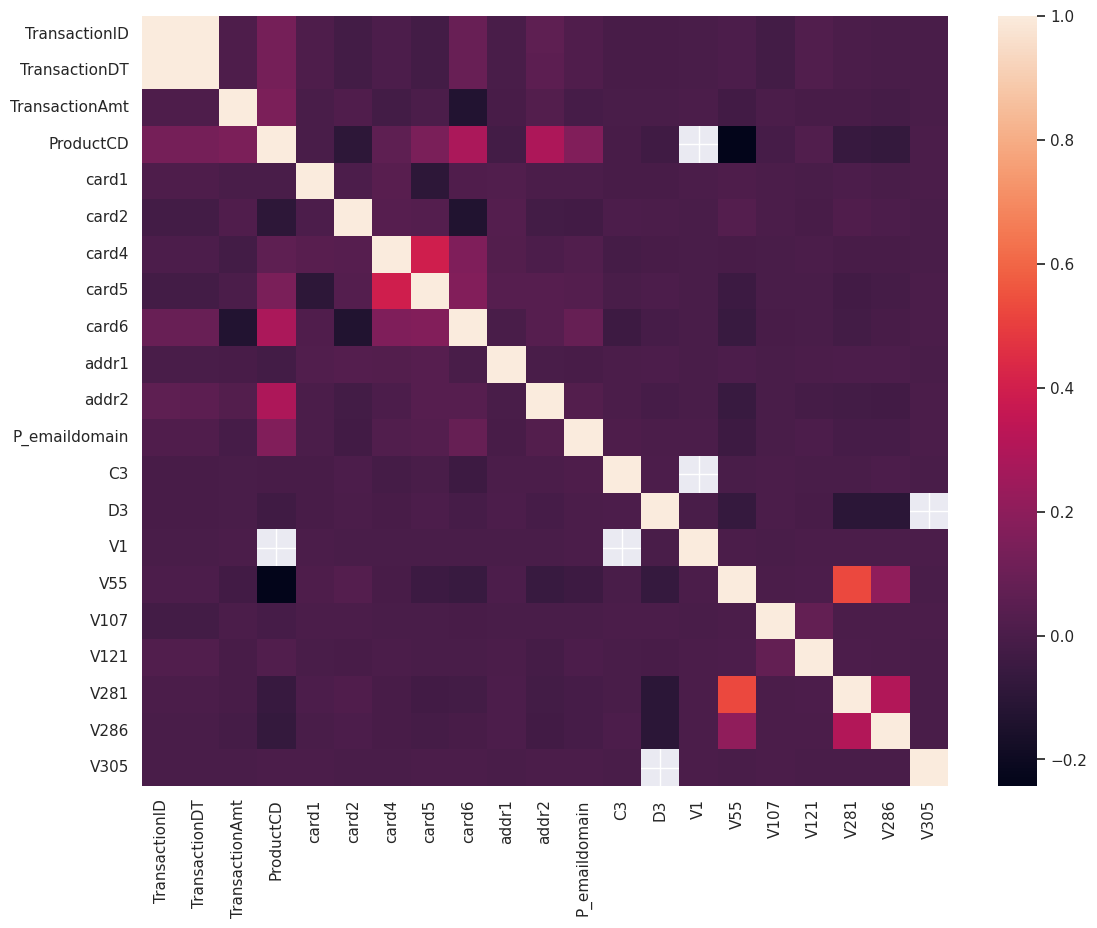

In [60]:
plt.figure(figsize=(13,10))
sns.heatmap(X_train.corr(), 
           xticklabels=X_train.columns, 
           yticklabels=X_train.columns)

Видим, что в датасете остались только слабо кореллированные признаки

### Посмотрим, есть ли в данных выбросы

Сперва отделим категориальные признаки от числовых

In [61]:
cat_feats = ['ProductCD', 'card1', 'card2', 'card4', 
             'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
num_feats = [x for x in X_train.columns if x not in cat_feats]
print(f'cat_feats:\n {cat_feats}\n')
print(f'num_feats:\n {num_feats}')

cat_feats:
 ['ProductCD', 'card1', 'card2', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']

num_feats:
 ['TransactionID', 'TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']


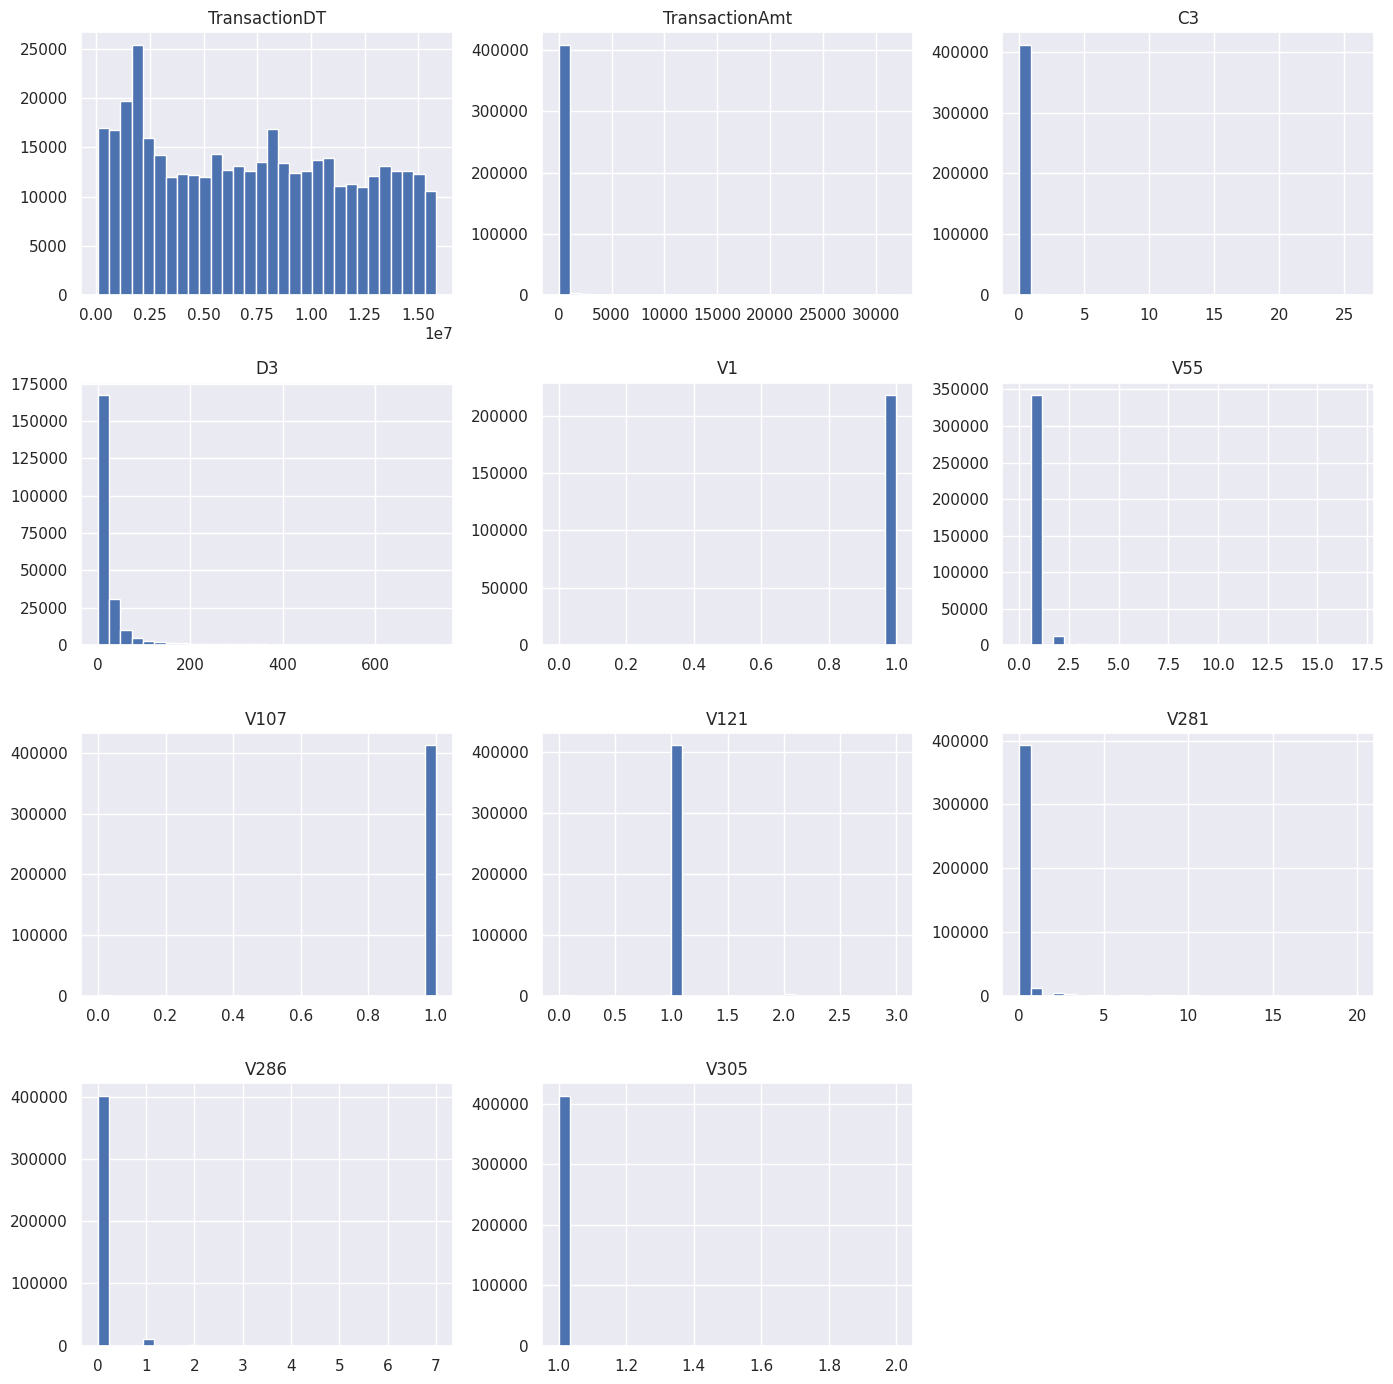

In [62]:
sns.set()
X_train[num_feats[1:]].hist(bins=30, figsize=(14,14))
plt.tight_layout()

Видим, что некоторые данные имеют выбросы. Посмотрим на графики ```boxplot```, чтобы явно убедиться в этом

In [63]:
def plt_boxplot(df, feature):
    sns.set()
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха {}'.format(feature))
    plt.xlabel(feature)
    plt.show()

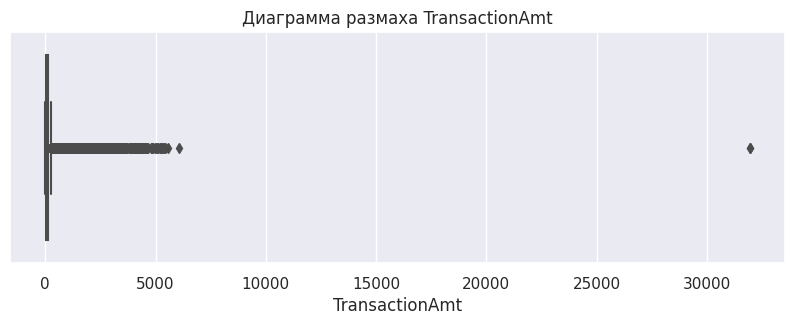

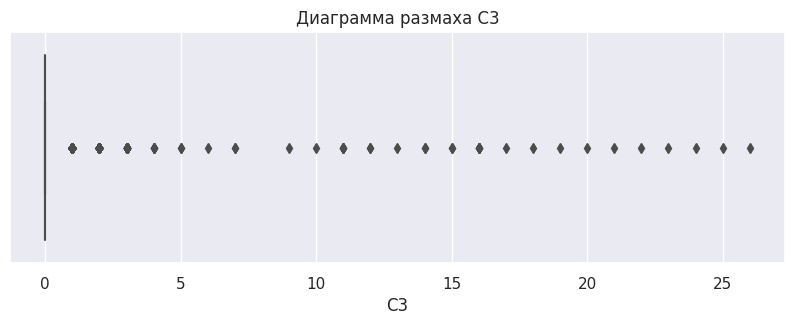

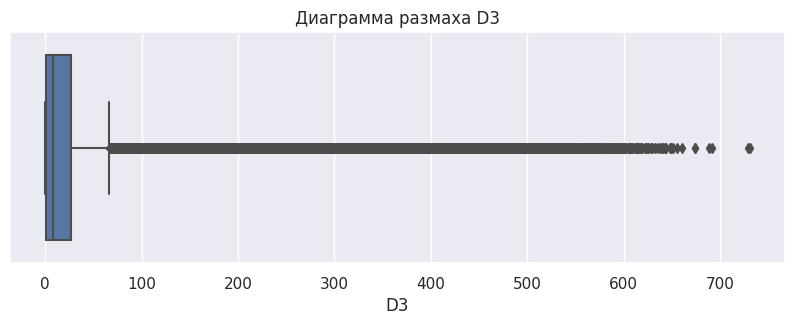

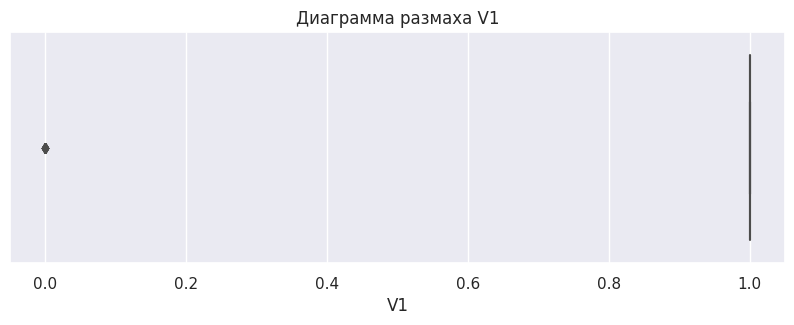

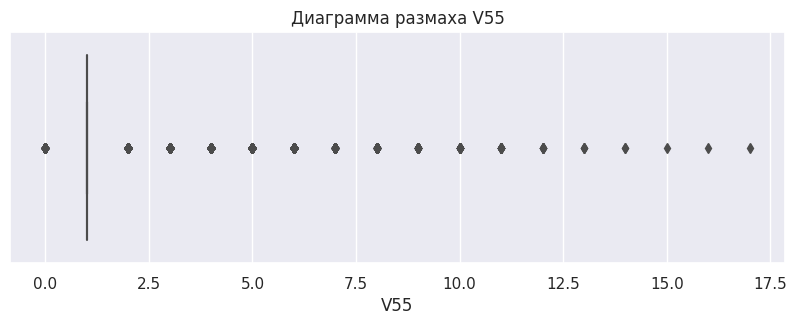

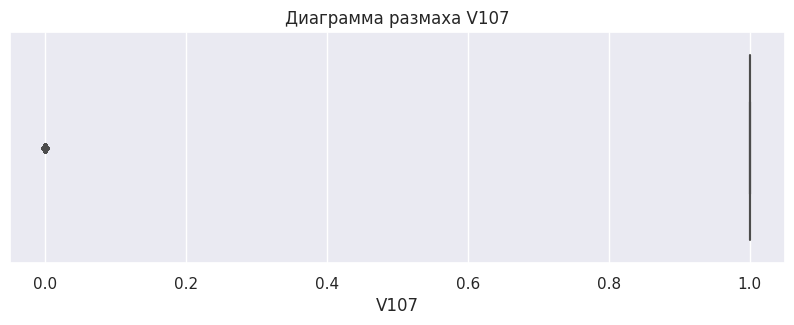

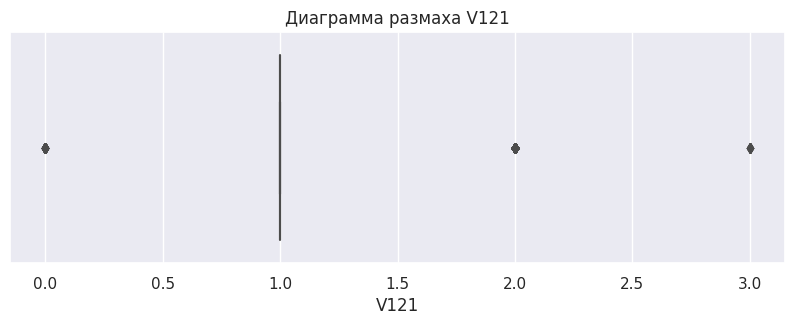

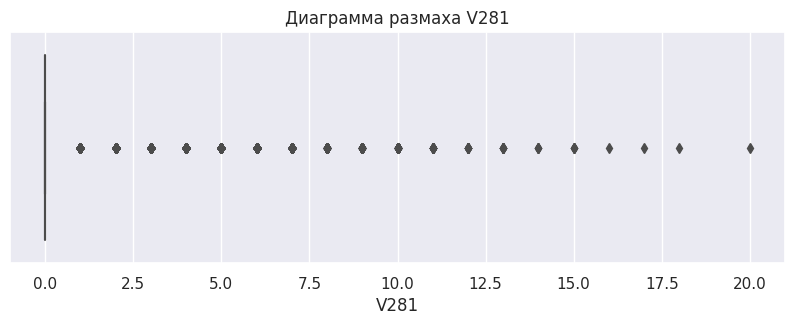

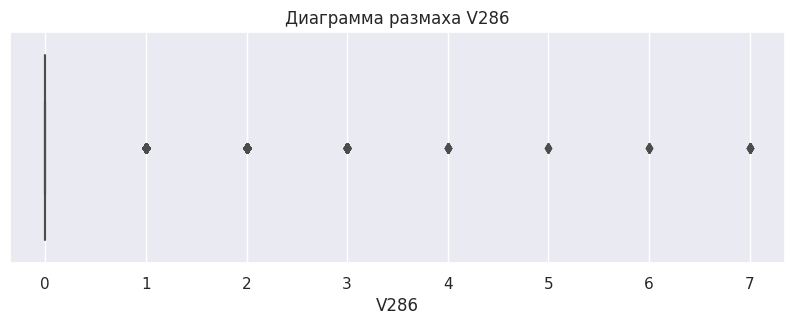

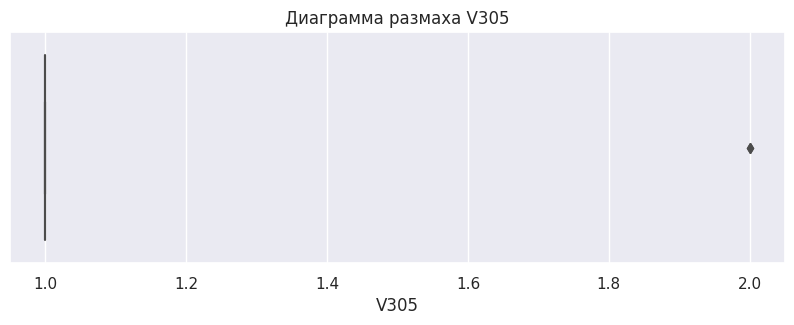

In [64]:
for feat in num_feats[2:]:
    plt_boxplot(X_train, feat)

Да, многие данные действительно имеют выбросы. Но сперва попробуем создать и обучить модели 

### Посмотрим ещё раз на пропуски

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 266381 to 317434
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   413378 non-null  uint32 
 1   TransactionDT   413378 non-null  uint32 
 2   TransactionAmt  413378 non-null  float32
 3   ProductCD       413378 non-null  int64  
 4   card1           413378 non-null  uint16 
 5   card2           407128 non-null  float32
 6   card4           413378 non-null  int64  
 7   card5           410349 non-null  float32
 8   card6           413378 non-null  int64  
 9   addr1           367409 non-null  float32
 10  addr2           367409 non-null  float32
 11  P_emaildomain   413378 non-null  int64  
 12  C3              413378 non-null  float32
 13  D3              229297 non-null  float32
 14  V1              217771 non-null  float32
 15  V55             359257 non-null  float32
 16  V107            413150 non-null  float32
 17  V121      

In [66]:
X_train.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6250
card4                  0
card5               3029
card6                  0
addr1              45969
addr2              45969
P_emaildomain          0
C3                     0
D3                184081
V1                195607
V55                54121
V107                 228
V121                 228
V281                 892
V286                   7
V305                   7
dtype: int64

Сперва заполним пропуски числовых признаков средним по колонке

Сделаем копии датасетов, чтобы ничего не поменять в исходниках

In [67]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_df_copy = test_df.copy()

In [68]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [69]:
X_train_copy[num_feats] = X_train_copy[num_feats].fillna(
    X_train_copy[num_feats].mean())

In [70]:
X_valid_copy[num_feats] = X_valid_copy[num_feats].fillna(
    X_valid_copy[num_feats].mean())

In [71]:
test_df_copy[num_feats] = test_df_copy[num_feats].fillna(
    test_df_copy[num_feats].mean())

Пропуски в категориальных прихнаках заполним константой ```-1```

In [72]:
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna(-1)
X_valid_copy[cat_feats] = X_valid_copy[cat_feats].fillna(-1)
test_df_copy[cat_feats] = test_df_copy[cat_feats].fillna(-1)

Проверки, остались ли пропуски в данных после заполнения

In [73]:
X_train_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [74]:
X_valid_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [75]:
test_df_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### Попробуем посмотреть на прогноз **логистической регрессии**

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
model_LR = LogisticRegression()

model_LR.fit(X_train_copy, y_train)

LogisticRegression()

In [78]:
y_pred_test_LR = model_LR.predict(X_valid_copy)

In [79]:
y_pred_test_LR

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [80]:
print(f'Доля верно угаданных объектов {(y_pred_test_LR == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


In [81]:
classifiers = [('DT', DecisionTreeClassifier()),
               ('RF', RandomForestClassifier()),
               ('Adaboost', AdaBoostClassifier()),
               ('GBM', GradientBoostingClassifier()),
               ('XGBBoost', XGBClassifier()),
               ('LightGBM', LGBMClassifier()),]